In [ ]:
!pip install pandas matplotlib tqdm transformer_lens

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformer_lens.utils import test_prompt
from transformer_lens import HookedTransformer
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load results
df = pd.read_csv('/content/drive/MyDrive/ioi-enumerate/medim_logits.csv')
print(df.columns)
print(df.shape)

Index(['template', 'PLACE', 'OBJECT', 'S', 'IO', 'text', 'prompt_toks',
       'logit_diff'],
      dtype='object')
(9313920, 8)


# Global Statistics

In [ ]:
# global mean and std
global_mean = df['logit_diff'].mean()
global_std = df['logit_diff'].std()

print("Global mean:", global_mean)
print("Global std:", global_std)

Global mean: 3.7937723299306807
Global std: 1.9872318046771653


(array([5.29963001e-07, 2.64981500e-06, 1.05992600e-06, 3.70974100e-06,
        6.35955601e-06, 3.17977800e-06, 5.29963001e-06, 4.45168920e-05,
        1.64288530e-05, 6.20056711e-05, 1.67998271e-04, 2.04035755e-04,
        3.95882361e-04, 4.79086552e-04, 9.39624400e-04, 1.02229863e-03,
        2.23167420e-03, 2.52686359e-03, 3.87455950e-03, 6.48197746e-03,
        9.31462970e-03, 1.32819327e-02, 1.84082648e-02, 2.68733638e-02,
        3.45694865e-02, 4.55958967e-02, 5.97210006e-02, 7.27050941e-02,
        8.94503350e-02, 1.04303078e-01, 1.20985253e-01, 1.36058991e-01,
        1.50790373e-01, 1.65152370e-01, 1.76711923e-01, 1.88309633e-01,
        1.94735435e-01, 1.98065722e-01, 2.01172365e-01, 2.02899515e-01,
        1.97033884e-01, 1.95027974e-01, 1.90150195e-01, 1.83205559e-01,
        1.75765409e-01, 1.67501696e-01, 1.59304228e-01, 1.50514262e-01,
        1.40080350e-01, 1.31538407e-01, 1.20735111e-01, 1.10835932e-01,
        1.01474666e-01, 9.16019848e-02, 8.19153211e-02, 7.384451

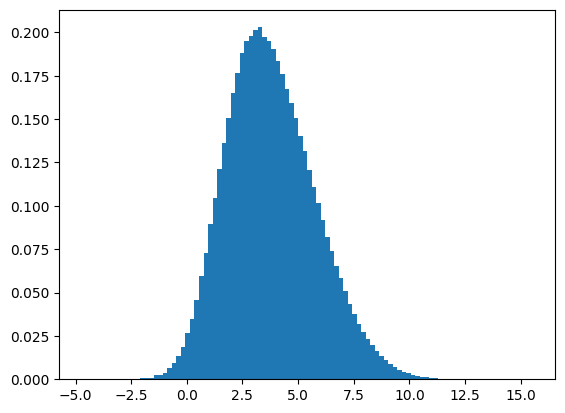

In [ ]:
# plot full histogram
plt.hist(df['logit_diff'], bins=100,  density=True)

In [ ]:
# Count number with logit diff < 0
print("# examples with logit diff < 0:\t", (df['logit_diff'] < 0).sum(), "out of", len(df))
print("% examples with logit diff < 0:\t", f"{((df['logit_diff'] < 0).sum() / len(df))*100:.3f}%")

# examples with logit diff < 0:	 125583 out of 9313920
% examples with logit diff < 0:	 1.348%


# Digging Down

In [ ]:
# Let's plot some of these extremes against the rest
def plot_against_alt(df, col, val, label_prefix=""):
    _, bins, _ = plt.hist(df['logit_diff'][df[col] != val], bins=100,  density=True, alpha=0.5, label=label_prefix+"All Others")
    plt.hist(df['logit_diff'][df[col] == val], bins=bins, density=True, alpha=0.5, label=f"{label_prefix}{col}:{val}")
    plt.legend()
    plt.show()

In [ ]:
subset_res_list = []
# check all template subsets
for col in ["template", "PLACE", "OBJECT", "S", "IO"]:
    print("Starting ", col)
    unique_vals = df[col].unique().tolist()
    for val in tqdm(unique_vals):
        subset_dict = {}
        subset_dict["col"] = col
        subset_dict["val"] = val

        subset_dict["mean"] = df['logit_diff'][df[col] == val].mean()
        subset_dict["std"] = df['logit_diff'][df[col] == val].std()
        subset_dict["alt_mean"] = df['logit_diff'][df[col] != val].mean()
        subset_dict["alt_std"] = df['logit_diff'][df[col] != val].std()

        subset_res_list.append(subset_dict)

Starting  template


100%|██████████| 15/15 [00:56<00:00,  3.74s/it]


Starting  PLACE


100%|██████████| 8/8 [00:31<00:00,  3.93s/it]


Starting  OBJECT


100%|██████████| 8/8 [00:33<00:00,  4.19s/it]


Starting  S


100%|██████████| 99/99 [05:58<00:00,  3.62s/it]


Starting  IO


100%|██████████| 99/99 [05:58<00:00,  3.62s/it]


In [ ]:
first_order_df = pd.DataFrame(subset_res_list)

In [ ]:
first_order_df["global_mean_diff"] = (first_order_df["mean"] - global_mean).abs()
first_order_df["global_std_diff"] = (first_order_df["std"] - global_std).abs()
first_order_df["relative_mean_diff"] = (first_order_df["mean"] - first_order_df["alt_mean"]).abs()
first_order_df["relative_std_diff"] = (first_order_df["std"] - first_order_df["alt_std"]).abs()

In [ ]:
first_order_df.sort_values("global_mean_diff", ascending=False).head(10)

,col,val,mean,std,alt_mean,alt_std,global_mean_diff,global_std_diff,relative_mean_diff,relative_std_diff
34,S,Jeffrey,6.501107,1.692153,3.766147,1.970943,2.707334,0.295079,2.734960,0.278790
100,S,Bradley,6.236655,1.688759,3.768845,1.974531,2.442882,0.298473,2.467810,0.285772
96,S,Kenneth,5.900351,2.173847,3.772277,1.973683,2.106578,0.186615,2.128074,0.200164
93,S,Lisa,1.799079,1.359751,3.814127,1.982299,1.994694,0.627481,2.015048,0.622548
5,template,When [B] and [A] got a [OBJECT] at the [PLACE]...,5.769635,1.697381,3.652640,1.930440,1.975863,0.289851,2.116996,0.233059
118,S,Alexander,5.687984,1.680786,3.774444,1.980802,1.894212,0.306446,1.913540,0.300016
4,template,When [B] and [A] got a [OBJECT] at the [PLACE]...,5.681712,1.696412,3.658920,1.937223,1.887940,0.290820,2.022792,0.240811
227,IO,Bradley,1.975523,1.668847,3.812326,1.981638,1.818250,0.318386,1.836803,0.312792
72,S,Amanda,1.993331,1.423134,3.812145,1.983761,1.800442,0.564099,1.818814,0.560627
76,S,Benjamin,5.457250,1.992060,3.776798,1.979993,1.663478,0.004828,1.680452,0.012067


In [ ]:
first_order_df.sort_values("relative_mean_diff", ascending=False).head(10)

,col,val,mean,std,alt_mean,alt_std,global_mean_diff,global_std_diff,relative_mean_diff,relative_std_diff
26,S,Bradley,5.686855,1.362495,2.812014,1.525202,2.845802,0.188031,2.874841,0.162707
66,S,Jeffrey,5.481752,1.333920,2.814107,1.529257,2.640699,0.216606,2.667645,0.195337
104,S,Alexander,4.819184,1.211386,2.820868,1.540570,1.978131,0.339140,1.998316,0.329184
208,IO,Angela,4.655091,1.733737,2.822542,1.537555,1.814038,0.183211,1.832549,0.196182
20,S,Lindsey,1.053393,1.312990,2.859294,1.542120,1.787660,0.237536,1.805901,0.229129
108,S,Amanda,1.166641,0.986863,2.858139,1.545907,1.674412,0.563663,1.691498,0.559043
212,IO,Bradley,1.245273,1.072404,2.857337,1.546183,1.595780,0.478122,1.612063,0.473778
171,IO,Amy,4.435444,1.738946,2.824784,1.540003,1.594391,0.188420,1.610660,0.198944
80,S,Lisa,1.292098,0.978007,2.856859,1.547312,1.548955,0.572519,1.564761,0.569304
114,S,Courtney,1.355508,1.045270,2.856212,1.547504,1.485545,0.505257,1.500704,0.502234


In [ ]:
first_order_df.sort_values("mean", ascending=True).head(10)

,col,val,mean,std,alt_mean,alt_std,global_mean_diff,global_std_diff,relative_mean_diff,relative_std_diff
55,S,Lisa,1.799079,1.359751,3.814126,1.982298,1.994694,0.627481,2.015048,0.622547
217,IO,Bradley,1.975522,1.668846,3.812326,1.981638,1.818251,0.318386,1.836804,0.312792
107,S,Amanda,1.993330,1.423132,3.812144,1.983761,1.800442,0.564100,1.818814,0.560628
68,S,Shannon,2.218303,2.007183,3.809849,1.980579,1.575470,0.019951,1.591546,0.026604
79,S,Vanessa,2.315721,1.543558,3.808854,1.985587,1.478052,0.443674,1.493134,0.442029
9,template,"Then, [B] and [A] had a long argument, and aft...",2.348366,1.598096,3.897016,1.972019,1.445407,0.389136,1.548650,0.373923
52,S,Mary,2.370382,1.602571,3.808297,1.985522,1.423390,0.384661,1.437914,0.382951
187,IO,David,2.377378,1.413634,3.808225,1.987037,1.416394,0.573598,1.430847,0.573403
33,S,Amy,2.383882,1.332779,3.808159,1.987655,1.409890,0.654453,1.424277,0.654876
12,template,"Then, [B] and [A] had a long argument. Afterwa...",2.405721,1.682761,3.892919,1.970141,1.388051,0.304471,1.487197,0.287380


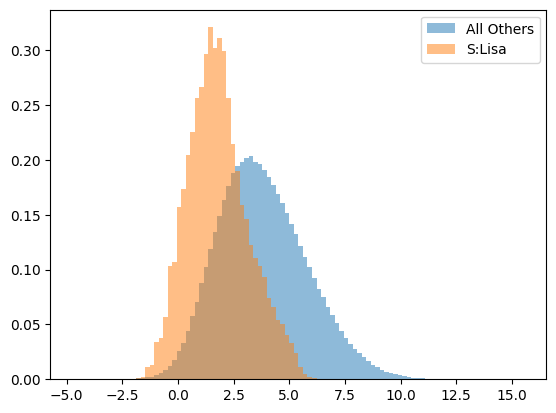

In [ ]:
plot_against_alt(df, 'S', 'Lisa', label_prefix="")

In [ ]:
s_df = df[df["S"] == "Lisa"]

In [ ]:
s_res_list = []
# check all template subsets
for col in ["template", "PLACE", "OBJECT", "IO"]:
    unique_vals = s_df[col].unique().tolist()
    for val in tqdm(unique_vals):
        subset_dict = {}
        subset_dict["col"] = col
        subset_dict["val"] = val

        subset_dict["mean"] = s_df['logit_diff'][s_df[col] == val].mean()
        subset_dict["std"] = s_df['logit_diff'][s_df[col] == val].std()
        subset_dict["alt_mean"] = s_df['logit_diff'][s_df[col] != val].mean()
        subset_dict["alt_std"] = s_df['logit_diff'][s_df[col] != val].std()

        s_res_list.append(subset_dict)

100%|██████████| 98/98 [00:04<00:00, 21.11it/s]


In [ ]:
s_res_df = pd.DataFrame(s_res_list)

In [ ]:
s_res_df.sort_values("mean", ascending=True).head(10)

,col,val,mean,std,alt_mean,alt_std
116,IO,Katie,0.017770,1.187264,1.817443,1.349228
108,IO,Alicia,0.196236,1.065318,1.815603,1.352604
101,IO,Michelle,0.206026,0.938098,1.815502,1.353694
99,IO,Samantha,0.232368,1.106246,1.815231,1.352706
33,IO,Lindsay,0.275709,0.938980,1.814784,1.354523
104,IO,Sara,0.385149,1.315619,1.813656,1.352529
98,IO,Laura,0.583636,0.955124,1.811610,1.357646
106,IO,Stephanie,0.594710,1.121147,1.811495,1.356440
127,IO,Kristen,0.614060,1.037480,1.811296,1.357303
76,IO,Christina,0.652787,1.077171,1.810897,1.357331


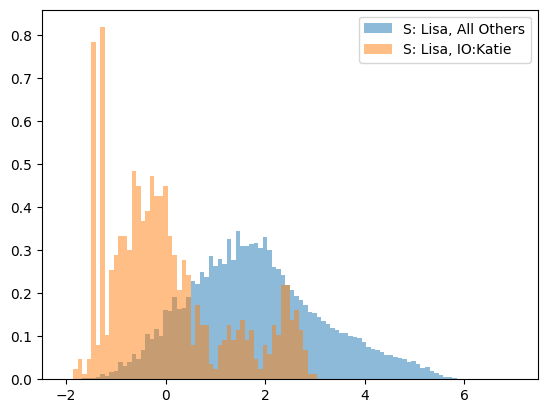

In [ ]:
plot_against_alt(s_df, "IO", "Katie", label_prefix="S: Lisa, ")

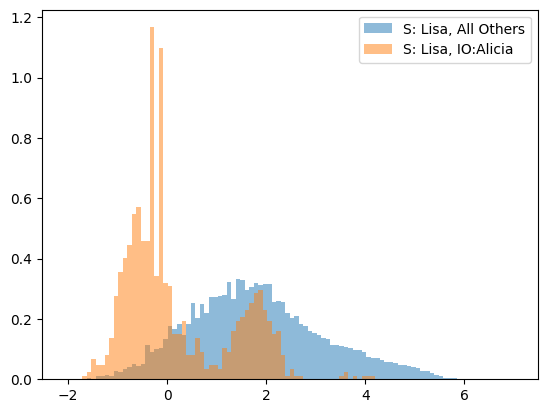

In [ ]:
plot_against_alt(s_df, "IO", "Alicia", label_prefix="S: Lisa, ")

In [ ]:
model = HookedTransformer.from_pretrained("gpt2")
tokenizer = model.tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2 into HookedTransformer


In [ ]:
lindmich_df = s_df[s_df["IO"] == "Alicia"]
toks = lindmich_df.iloc[0]['prompt_toks'][1:-1].split(', ')
toks = [int(t) for t in toks]
prompt = tokenizer.decode(toks)
prompt

'Then, Lisa and Alicia had a long argument, and afterwards Lisa said to'

In [ ]:
test_prompt(prompt, "Alicia", model)

Tokenized prompt: ['<|endoftext|>', 'Then', ',', ' Lisa', ' and', ' Alicia', ' had', ' a', ' long', ' argument', ',', ' and', ' afterwards', ' Lisa', ' said', ' to']
Tokenized answer: [' Alicia']


Performance on answer token:
Rank: 2        Logit: 16.66 Prob: 23.83% Token: | Alicia|

Top 0th token. Logit: 16.75 Prob: 26.04% Token: | Lisa|
Top 1th token. Logit: 16.75 Prob: 26.02% Token: | her|
Top 2th token. Logit: 16.66 Prob: 23.83% Token: | Alicia|
Top 3th token. Logit: 14.27 Prob:  2.18% Token: | me|
Top 4th token. Logit: 14.18 Prob:  1.98% Token: | the|
Top 5th token. Logit: 13.59 Prob:  1.10% Token: | them|
Top 6th token. Logit: 13.52 Prob:  1.02% Token: | him|
Top 7th token. Logit: 13.46 Prob:  0.97% Token: | herself|
Top 8th token. Logit: 12.52 Prob:  0.38% Token: | us|
Top 9th token. Logit: 12.30 Prob:  0.30% Token: | Amy|


Ranks of the answer tokens: [(' Alicia', 2)]